<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Distribution Transformations

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy, https://geostatsguy.github.io/GeostatsPyDemos_Book.  
```

The workflows in this book and more are available here:

```{admonition} Cite the GeostatsPyDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, GeostatsPyDemos: GeostatsPy Python Package for Spatial Data Analytics and Geostatistics Demonstration Workflows Repository (0.0.1). Zenodo. https://zenodo.org/doi/10.5281/zenodo.12667035

[![DOI](https://zenodo.org/badge/777871341.svg)](https://zenodo.org/doi/10.5281/zenodo.12667035)

```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of **Distribution Transformations**. 

**YouTube Lecture**: check out my lecture on [Distribution Transformations](https://youtu.be/ZDIpE3OkAIU?si=H1KY-KDswVlEFyZh). For your convenience here's a summary of salient points.

Here's a simple workflow with some basic univariate distribution transformations for subsurface modeling workflows. This should help you get started data transformations.  

#### Data Distribution Transformations

Why do we perform distribution transformations in geostatistical methods and workflows?:

* variable has expected shape / correcting for too few data
  
* a specific distribution assumption is required
  
* correct for outliers

We will cover three methods:

1. **Affine correction** - rescaling the distribution mean and variance without shape change

2. **Normal score transform** - transformation to a Gaussian distribution with shape change

3. **General distribution transformation** - transformation to any parametric or nonparametric target distribution with shape change

I'll provide some for information on each in the workflow flow.

#### Load the Required Libraries

The following code loads the required libraries. 

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))        

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from scipy import stats                                       # summary statistics
from scipy.stats import norm                                  # Gaussian parametric distribution
from statsmodels.stats.weightstats import DescrStatsW         # any weighted statistics
import math                                                   # trig etc.
import scipy.signal as signal                                 # kernel for moving window calculation
import random
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map
seed = 13                                                     # random number seed

#### Declare functions

This is a convenience function to add major and minor gridlines to improve plot interpretability.

In [3]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("c:/PGE383/Examples")                               # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [5]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load our data form my GitHub account
print('Using ' + str(len(df)) + ' number of samples')
df.head(n=3)                                                  # preview the data table

Using 289 number of samples


,X,Y,Facies,Porosity,Perm
0,100,900,1,0.115359,5.736104
1,100,800,1,0.136425,17.211462
2,100,600,1,0.135810,43.724752


It worked, we loaded our file into our DataFrame called 'df'. But how do you really know that it worked? Visualizing the DataFrame would be useful and we already learned about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). 

* With the slice we could look at any subset of the data table and with the head command, add parameter 'n=3' to see the first 3 rows of the dataset. 

#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. 

* The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. 

* We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [6]:
df.describe().transpose()                                     # summary statistics

,count,mean,std,min,25%,50%,75%,max
X,289.0,475.813149,254.277530,0.000000,300.000000,430.000000,670.000000,990.000000
Y,289.0,529.692042,300.895374,9.000000,269.000000,549.000000,819.000000,999.000000
Facies,289.0,0.813149,0.390468,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,289.0,0.134744,0.037745,0.058548,0.106318,0.126167,0.154220,0.228790
Perm,289.0,207.832368,559.359350,0.075819,3.634086,14.908970,71.454424,5308.842566


#### Visualizing Tabular Data with Location Maps 

It is natural to set the x and y coordinate and feature ranges manually, e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display. 

* I heard that plasma and inferno are known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). 

* We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [7]:
xmin = 0.0; xmax = 1000.0                                     # range of x values
ymin = 0.0; ymax = 1000.0                                     # range of y values
pormin = 0.05; pormax = 0.25;                                 # range of porosity values

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [8]:
GSLIB.locmap

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

Now we can populate the plotting parameters and visualize the porosity data.

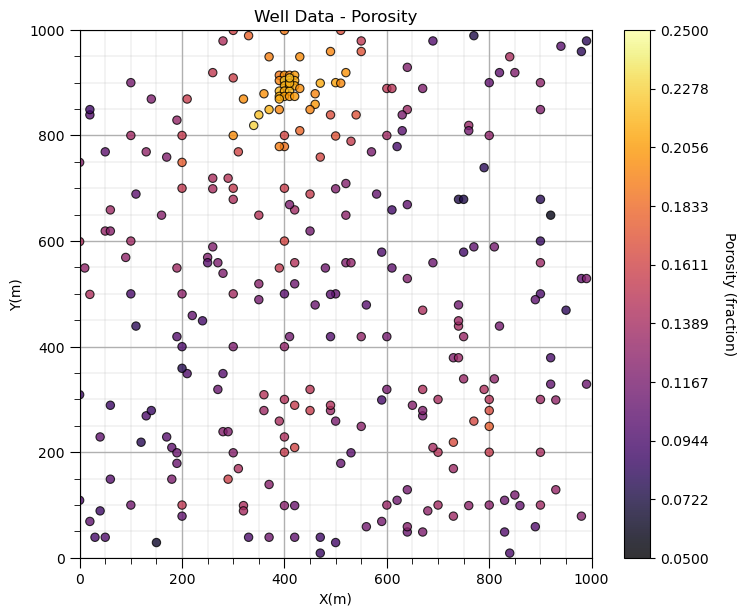

In [9]:
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)
add_grid(); plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Decluster the Data

Look carefully, and you'll notice that the spatial samples are more dense in the high porosity regions and less dense in the low porosity regions. There is preferential sampling. 

* We cannot use the naive statistics to represent this region. We have to correct for the clustering of the samples in the high porosity regions. 

* Let's try cell declustering. We can interpret that we will want to minimize the declustering mean and that a cell size of between 100 - 200m is likely a good cell size, this is 'an ocular' estimate of the largest average spacing in the sparsely sampled regions.   

Let's check out the declus program in GeostatsPy. Of course, I have a couple complete workflows for declustering with GeostatsPy that provide more complete descriptions.

In [10]:
geostats.declus                                               # GeostatsPy's declustering program

<function geostatspy.geostats.declus(df, xcol, ycol, vcol, iminmax, noff, ncell, cmin, cmax)>

We can now populate the parameters. We will run a very wide range of cell sizes, from 10m to 2,000m ('cmin' and 'cmax') and take the cell size that minimizes the declustered mean ('iminmax' = 1 minimize, and = 0 maximize). Multiple offsets (number of these is 'noff') uses multiple grid origins and averages the results to remove sensitivity to grid position.  The ncell is the number of cell sizes.

The output from this program is:

* wts - an array with the weights for each data (they sum to the number of data, 1 indicates nominal weight)
* cell_sizes - an array with the considered cell sizes
* dmeans - de an 

In [11]:
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['Porosity_Wts'] = wts                                               # add weights to the sample data DataFrame
df.head()                                                     # preview to check the sample data DataFrame

There are 289 data with:
   mean of      0.13474387540138408 
   min and max  0.058547873 and 0.228790002
   standard dev 0.03767982164385208 


,X,Y,Facies,Porosity,Perm,Porosity_Wts
0,100,900,1,0.115359,5.736104,3.064286
1,100,800,1,0.136425,17.211462,1.076608
2,100,600,1,0.135810,43.724752,0.997239
3,100,500,0,0.094414,1.609942,1.165119
4,100,100,0,0.113049,10.886001,1.224164


Let's look at the location map of the weights.

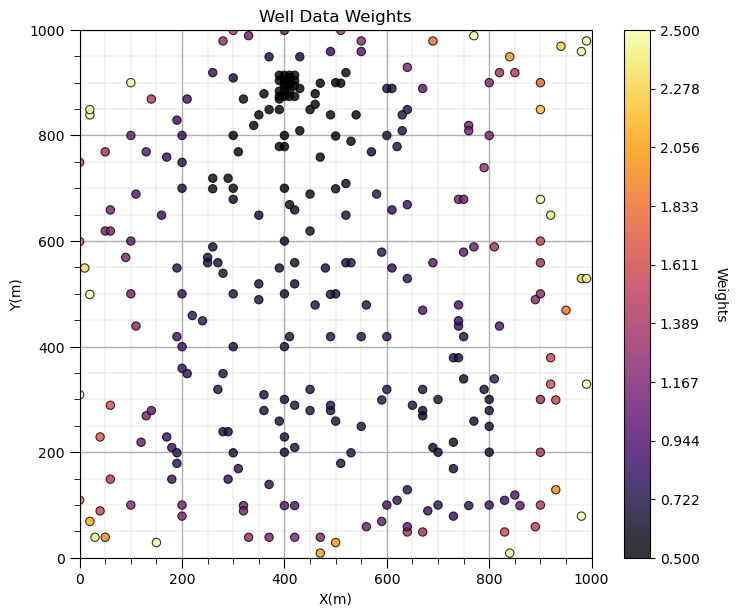

In [12]:
GSLIB.locmap_st(df,'X','Y','Porosity_Wts',xmin,xmax,ymin,ymax,0.5,2.5,'Well Data Weights','X(m)','Y(m)','Weights',cmap); 
add_grid(); plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Does it look correct?  See the weight varies with local sampling density?  

Now let's add the distribution of the weights and the naive and declustered porosity distributions. You should see the histogram bars adjusted by the weights. Also note the change in the mean due to the weights. There is a significant change.

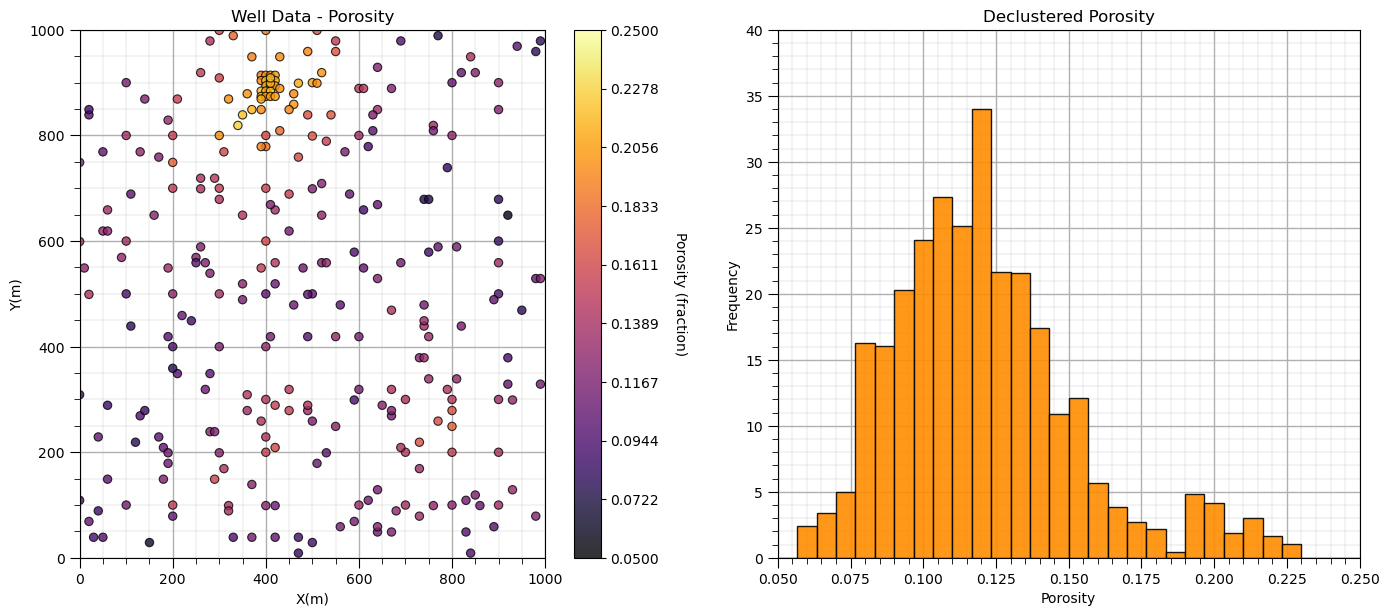

In [13]:
plt.subplot(121)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap); add_grid()

plt.subplot(122)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=30,weights=df['Porosity_Wts'],xlabel="Porosity",title="Declustered Porosity")
plt.ylim(0.0,40); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Now we can calculate the representative statistics:

* declustered mean
* declustered standard deviation

In [14]:
weighted_data = DescrStatsW(df['Porosity'].values, weights=df['Porosity_Wts'], ddof=0)
dmean = weighted_data.mean;  dstdev = weighted_data.std

print('Declustered, Weighted Statistics:')
print('  Mean: ' + str(round(dmean,3)))
print('  Standard Deviation: ' + str(round(dstdev,3)))
print('  Variance: ' + str(round(weighted_data.var,5)))

Declustered, Weighted Statistics:
  Mean: 0.121
  Standard Deviation: 0.032
  Variance: 0.00102


We are now ready to do some data transformations.

#### Distribution Rescaling / Affine Correction

Distribution rescaling can be thought of as shifting, and stretching and squeezing a distribution. The common method is known as affine correction:

$$
y = \frac{\sigma_y}{\sigma_x}(x - \overline{x}) + \overline{y}
$$

We can see above that the affine correlation method first centers the distribution, the rescales the dispersion based on the ratio of the new standard deviation to the original standard deviation and then shifts the distribution to centered on the target mean.

We have a function in GeostatsPy to do the affine correction of the distribution.

In [15]:
GSLIB.affine                                                  # GeostatsPy's affine correction function

<function geostatspy.GSLIB.affine(array, tmean, tstdev)>

We just need to specify the new target mean and variance.  Let's make 2 new rescaled distributions and then plot the results.

##### Affine Standardization

If we correct the mean to 0.0 and the variance (and standard deviation) to 1.0, we have standardized our feature.

Affine Transformed Distribution Statistics:
  Mean: 0.0
  Standard Deviation: 1.0
  Variance: 1.0


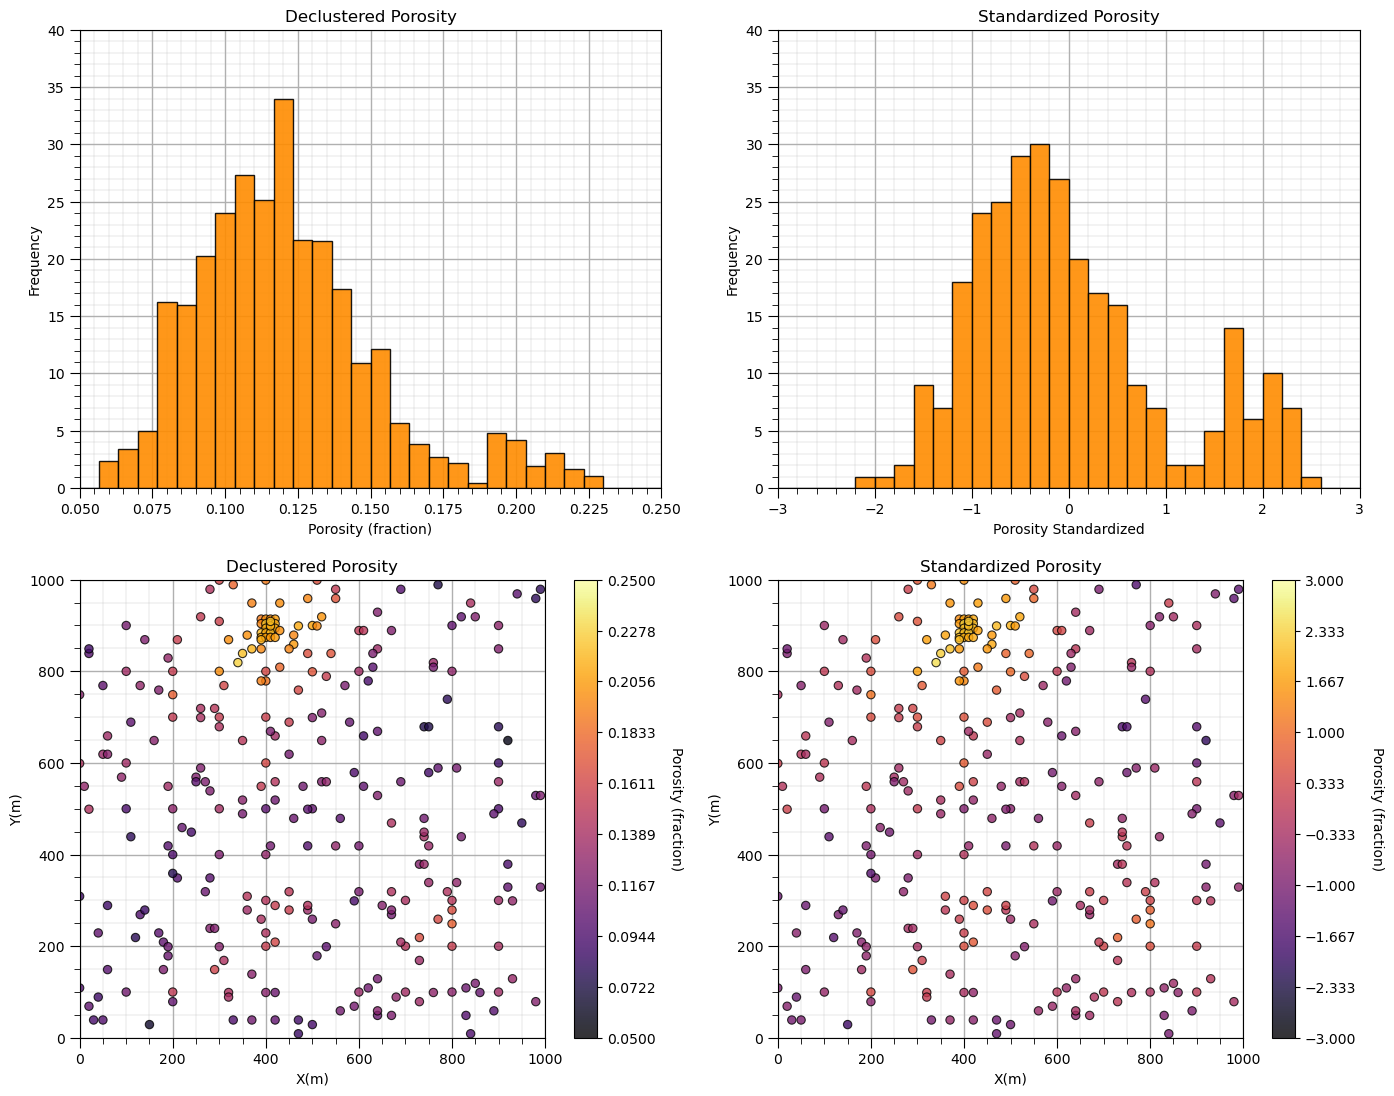

In [16]:
por1 = GSLIB.affine(df['Porosity'].values,0.0,1.0)            # rescale the porosity to have a standard distribution
df['stand_Por'] = por1                                        # add transformed data to the DataFrame

plt.subplot(221)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=30,weights=df['Porosity_Wts'],xlabel="Porosity (fraction)",title="Declustered Porosity")
plt.ylim(0.0,40); add_grid()

plt.subplot(222)
GSLIB.hist_st(df['stand_Por'],-3.0,3.0,log=False,cumul=False,bins=30,weights=None,xlabel="Porosity Standardized",title="Standardized Porosity")
plt.ylim(0.0,40); add_grid()

plt.subplot(223)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Declustered Porosity','X(m)','Y(m)','Porosity (fraction)',cmap); add_grid()

plt.subplot(224)
GSLIB.locmap_st(df,'X','Y','stand_Por',xmin,xmax,ymin,ymax,-3,3,'Standardized Porosity','X(m)','Y(m)','Porosity (fraction)',cmap); add_grid()

print('Affine Transformed Distribution Statistics:')
print('  Mean: ' + str(round(np.average(por1),3)))
print('  Standard Deviation: ' + str(round(np.std(por1),3)))
print('  Variance: ' + str(round(np.var(por1),5)))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

Let's make some observations:

* Notice that I did not say standard normal? A standard distribution has a mean of 0.0 and standard deviation of 1.0.  The rescaling does not change the distribution shape; therefore, a non-normal (non-Gaussian) distribution cannot become normal (Gaussian) shaped just by rescaling.  We'll cover the Gaussian transformation in a bit.

* Also, notice that the shape is the same and the location maps look almost the same? By adjusting the minimum and maximum values in the histogram x-axis and the location map color bar, we made them look unchanged! There are minor differences in bars due to the precise locations of the bin boundaries.  

Let's try a minor adjustment as in the case of correcting the porosity to a more representative declustered mean and standard deviation. 

Affine Transformed Distribution Statistics:
  Mean: 0.121
  Standard Deviation: 0.032
  Variance: 0.00102


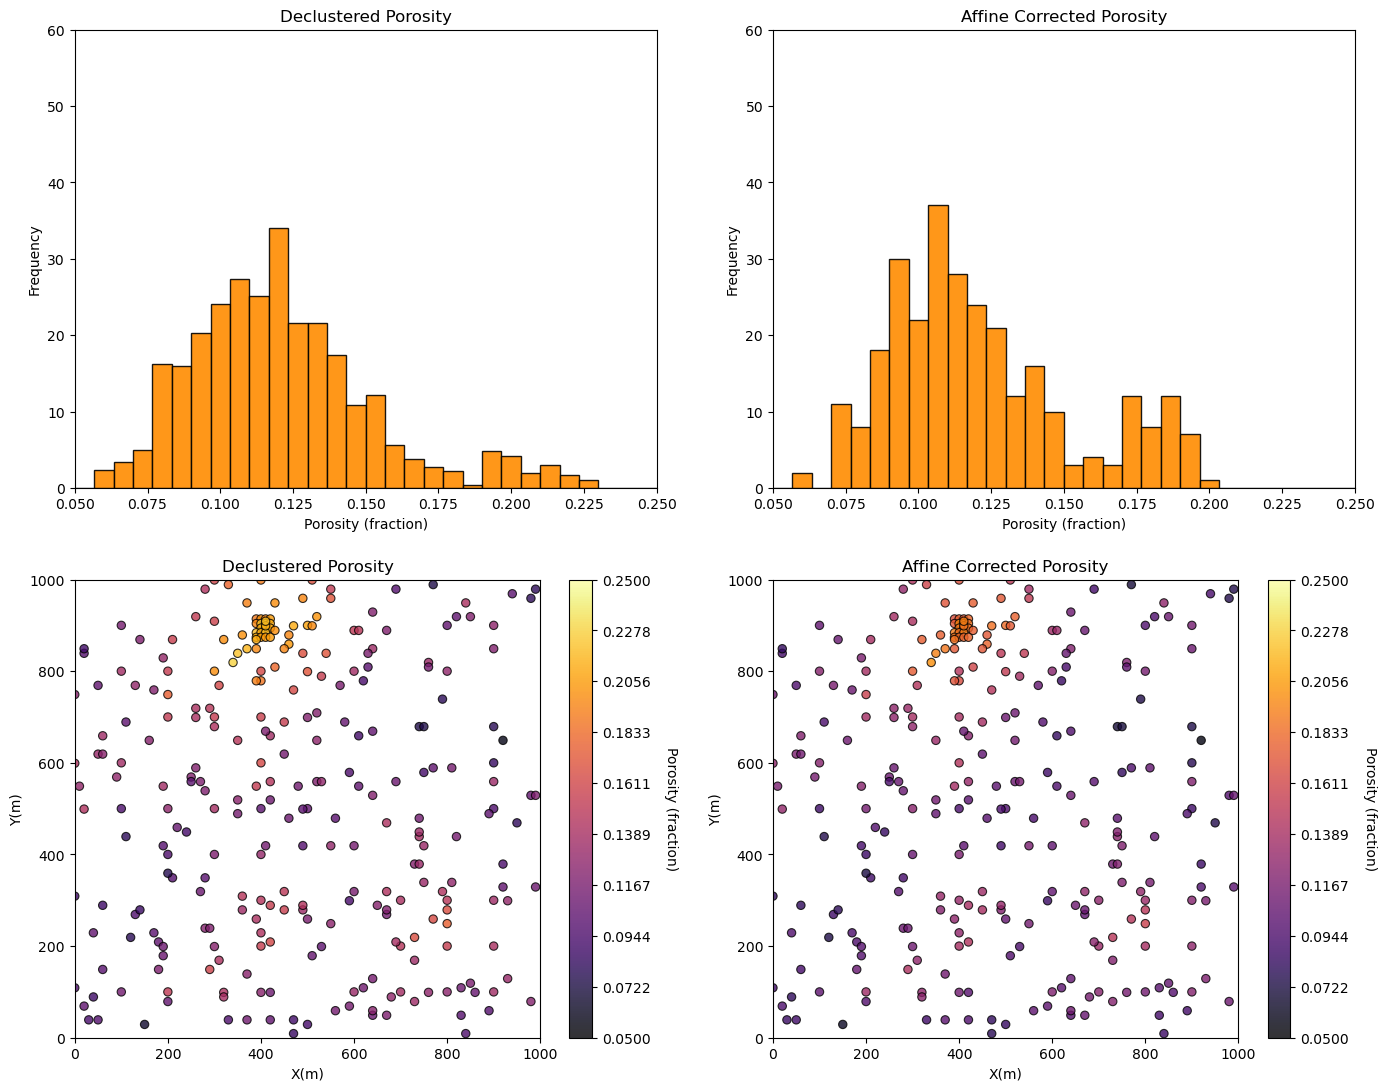

In [17]:
target_mean = dmean; target_stdev = dstdev                    # target mean and standard deviation for affine correction

por2 = GSLIB.affine(df['Porosity'].values,target_mean,target_stdev) # rescale the porosity to have a standard distribution
df['affine_Por'] = por2                                       # add transformed data to the DataFrame

plt.subplot(221)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=30,weights=df['Porosity_Wts'],xlabel="Porosity (fraction)",title="Declustered Porosity")
plt.ylim(0.0,60)

plt.subplot(222)
GSLIB.hist_st(df['affine_Por'],0.05,0.25,log=False,cumul=False,bins=30,weights=None,xlabel="Porosity (fraction)",title="Affine Corrected Porosity")
plt.ylim(0.0,60)

plt.subplot(223)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Declustered Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(224)
GSLIB.locmap_st(df,'X','Y','affine_Por',xmin,xmax,ymin,ymax,0.05,0.25,'Affine Corrected Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)

print('Affine Transformed Distribution Statistics:')
print('  Mean: ' + str(round(np.average(por2),3)))
print('  Standard Deviation: ' + str(round(np.std(por2),3)))
print('  Variance: ' + str(round(np.var(por2),5)))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

Note that the distribution mean, standard deviation and variance are corrected to the more representative values. 

Note, affine correction is often applied to calculate multiple scenarios of the feature distribution (more on these uncertainty methods later).

* be careful about the potential for non-physical values if there are large changes, e.g., negative porosity.

#### Normal Score Transform / Gaussian Anamorphosis

We showed that the correction of the mean to 0.0 and standard deviation to 1.0 with affine correction does not change the shape; therefore, does not make a Gaussian distributed property. 

* for many statistic or geostatistical methods the assumption of Gaussian distributed is required. We need normal score transforms in many subsurface modeling workflows

Gaussian anamorphosis is applied through the cumulative distribution functions (CDF)s, $F_{X}$, to a new CDF , $G_{Y}$. This can be generalized with the quantile - quantile transformation applied to all the sample data:   

* The forward transform:

$$
Y = G_{Y}^{-1}(F_{X}(X))
$$


* The reverse transform:

$$
X = F_{X}^{-1}(G_{Y}(Y))
$$

Here's a visualization of the Gaussian transformation,

<figure style="text-align: center;">
  <img src="_static/transformations/norm_score.png" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Gaussian anamorphosis to transform the original distribution to standard normal, Gaussian shape with a mean of 0.0 and variance of 1.0.
</figcaption>
</figure>

Let's check out the GSLIB NSCORE program translated to Python in GeostatsPy.

In [18]:
geostats.nscore                                               # GeostatsPy's Gaussian transformation function

<function geostatspy.geostats.nscore(df, vcol, wcol=None, ismooth=False, dfsmooth=None, smcol=0, smwcol=0)>

The inputs are primarily the DataFrame, the variable and the data weight columns ('df', 'vcol' and 'wcol'). 

* The remainder of the variables are for the use of a reference distribution. When would you use a reference distribution? This would be the case when you have too few data to perform a reliable transformation and use analog information to inform a more complete distribution to support the transformation.  

* As you can see the inputs from weights column ('wcol') have defaults of 0. You can run the function omitting these (e.g. just DataFrame and variable column etc.).

* The output form the program include the transformed data, and the transformation table (discretized values in original and associated Gaussian space). 

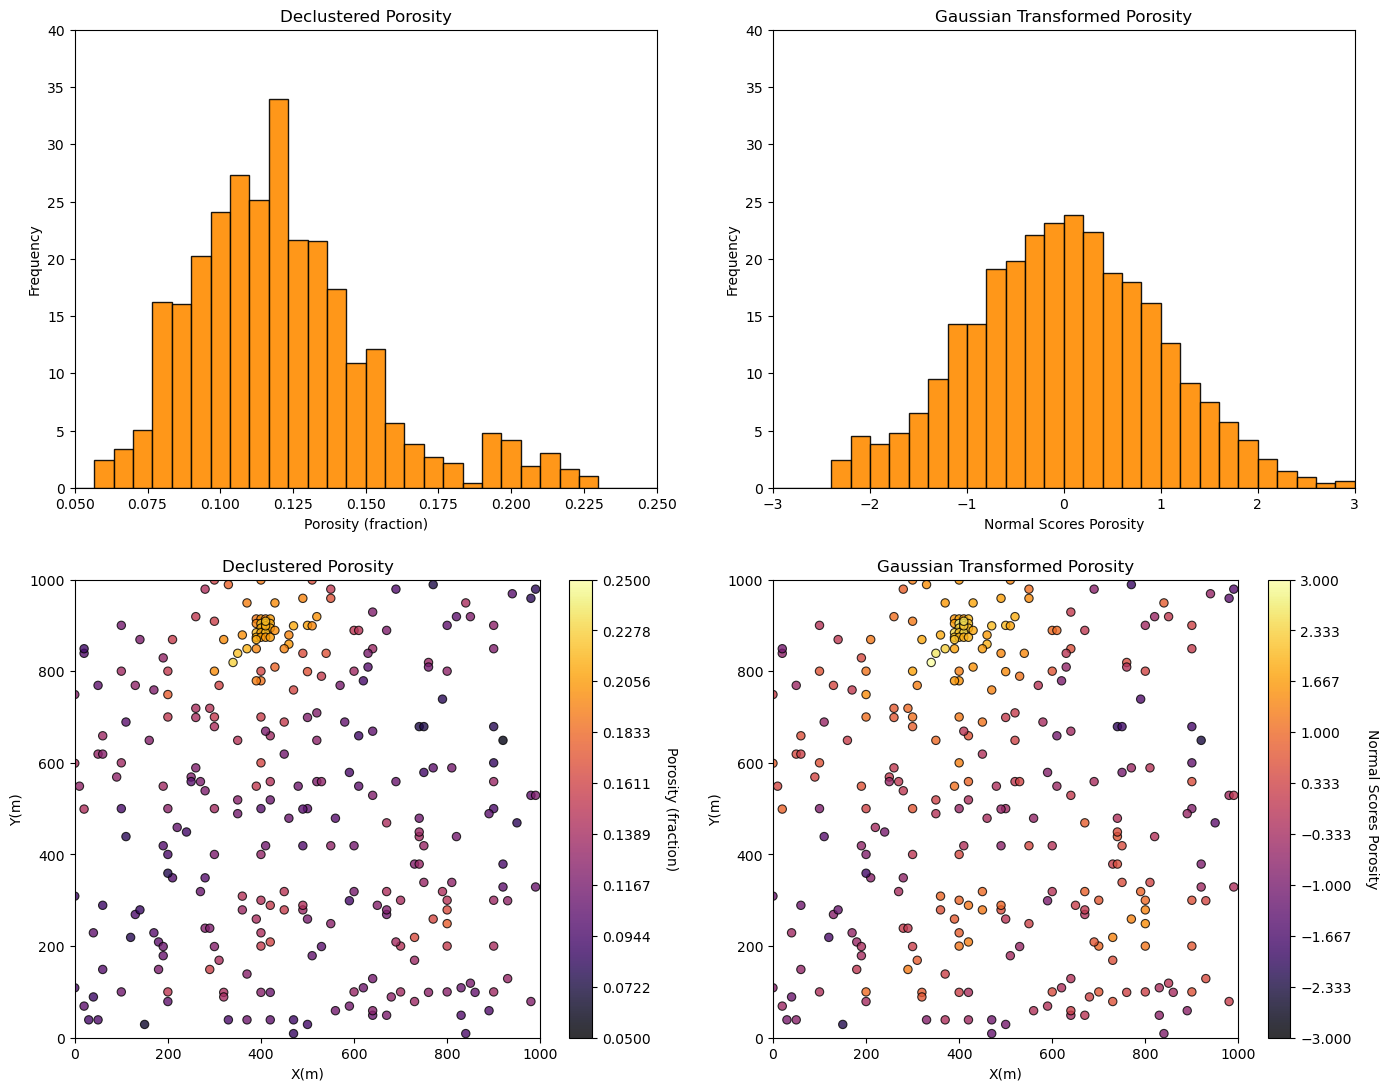

In [19]:
ns_por,trans_vr,trans_ns = geostats.nscore(df,'Porosity','Porosity_Wts') # Gaussian (NSCORE) transformation
df['NPor'] = ns_por                                           # add transformed data to the DataFrame                                   # 

plt.subplot(221)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=30,weights=df['Porosity_Wts'],xlabel="Porosity (fraction)",title="Declustered Porosity")
plt.ylim(0.0,40)

plt.subplot(222)
GSLIB.hist_st(df['NPor'],-3.0,3.0,log=False,cumul=False,bins=30,weights=df['Porosity_Wts'],xlabel="Normal Scores Porosity",title="Gaussian Transformed Porosity")
plt.ylim(0.0,40)

plt.subplot(223)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Declustered Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(224)
GSLIB.locmap_st(df,'X','Y','NPor',xmin,xmax,ymin,ymax,-3.0,3.0,'Gaussian Transformed Porosity','X(m)','Y(m)','Normal Scores Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2)
plt.show()

Some observations:

* That is interesting! Why is the new distribution not perfectly Gaussian in shape? Because it is the declustered distribution of the data transformed to Gaussian. It accounts for the spatial bias in the sampling.

* I'm not completely satisfied with the behavior of the transformed data distribution at the tails.  The NSCORE programs does not have any tail extrapolation model as found with simulation methods. The transform at the tails is hard to do just from the data alone. When we get into simulation methods we'll check that out.

We should also visualize the transformation table with a Q-Q plot.

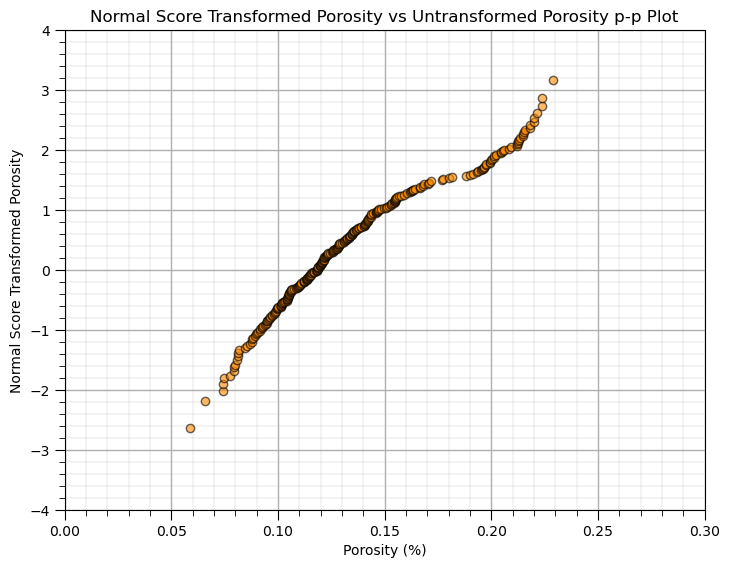

In [20]:
plt.subplot(111)
plt.scatter(trans_vr,trans_ns, c = "darkorange",edgecolor='black',marker='o', alpha = 0.6)
plt.xlabel('Porosity (%)')
plt.ylabel('Normal Score Transformed Porosity')
plt.title('Normal Score Transformed Porosity vs Untransformed Porosity p-p Plot')
plt.ylim(-4,4); plt.xlim(0,.30); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

This is a q-q plot that maps the transform from our original distribution to the Gaussian distribution. Notice how the declustering weights have shifted the lower quantiles to above an imaginary line through the points as they received more declustering weight.  

As a final step we should check out the summary statistics of all the variants of porosity from our various data transformations.  

In [21]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,289.0,4.758131e+02,254.277530,0.000000,300.000000,430.000000,670.000000,990.000000
Y,289.0,5.296920e+02,300.895374,9.000000,269.000000,549.000000,819.000000,999.000000
Facies,289.0,8.131488e-01,0.390468,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,289.0,1.347439e-01,0.037745,0.058548,0.106318,0.126167,0.154220,0.228790
Perm,289.0,2.078324e+02,559.359350,0.075819,3.634086,14.908970,71.454424,5308.842566
Porosity_Wts,289.0,1.000000e+00,0.639743,0.281976,0.670642,0.789486,1.174123,3.984325
stand_Por,289.0,1.475175e-16,1.001735,-2.022196,-0.754414,-0.227615,0.516880,2.495928
affine_Por,289.0,1.212482e-01,0.031916,0.056819,0.097212,0.113996,0.137716,0.200771
NPor,289.0,3.876516e-01,1.042739,-2.336338,-0.330268,0.331970,1.118825,3.157063


#### General Distribution Transformation

The distribution transformation may be applied to transform any distribution, $F_x(x)$ to any other distribution, $F_y(y)$.

* the target distribution, $F_y(y)$, could be nonparametric, i.e., a set of values. In this case the data is converted to a CDF and some form of interpolation is applied to find the inverse of the target CDF, $F_y^{-1}(p)$, for any cumulative probability, $p$

* the target distribution, $F_y(y)$, could be any parametric distribution, and the calculation of the inverse of the target CDF, $F_y^{-1}(p)$, for any cumulative probability, $p$ is available through an analytical solution

I have built out an interactive Python dashboard [Distribution Transformation](https://github.com/GeostatsGuy/DataScienceInteractivePython/blob/main/Interactive_Distribution_Transformations.ipynb) with a transformation to a parametric distribution,

<figure style="text-align: center;">
  <img src="_static/transformations/interactive_transforms_par.png" style="display: block; margin: 0 auto; width: 100%;">
  <figcaption style="text-align: center;"> Interactive Python dashboard for distribution transformation to a parametric target distribution.
</figcaption>
</figure>

and a transformation to a nonparametric distribution,

<figure style="text-align: center;">
  <img src="_static/transformations/interactive_transforms_nonpar.png" style="display: block; margin: 0 auto; width: 100%;">
  <figcaption style="text-align: center;"> Interactive Python dashboard for distribution transformation to a nonparametric target distribution.
</figcaption>
</figure>

#### Distribution Transformation to a Parametric Distribution

We can transform our data feature distribution to any parametric distribution with this workflow.

1. Calculate the cumulative probability value of each of our data values, $p_{\alpha} = F_x(x_\alpha)$, $\forall$ $\alpha = 1,\ldots, n$.

2. Apply the inverse of the target parametric cumulative distribution function (CDF) to calculate the transformed values. $y_{\alpha} = G_y^{-1}\left(F_x(x_\alpha)\right)$, $\forall$ $\alpha = 1,\ldots, n$.

While assigning the cumulative probabilities you must make an assumption about the distribution tails (minimum and maximum values).

* **known tail** - the minimum or maximum value in the dataset is the minimum or maximum value of the distribution

* **unknown tail** - the minimum or maximum value of the distribution is known

For each possible case we calculate cumulative probability of the sorted in ascending order data as,

1. known lower and upper tail,

$$
F_i = \frac{i-1}{n-1}
$$

2. unknown lower and known upper tail,

$$
F_i = \frac{i}{n}
$$

3. known lower and unknown upper tail,

$$
F_i = \frac{i-1}{n}
$$

4. unknown upper and lower tail,

$$
F_i = \frac{i}{n+1}
$$ 

this is more important with sparsely sampled datasets. When $n$ is large this is not as important,

* the range of cumulative probability at the tails is very small!

* the minimum and maximum of the feature may be well-known

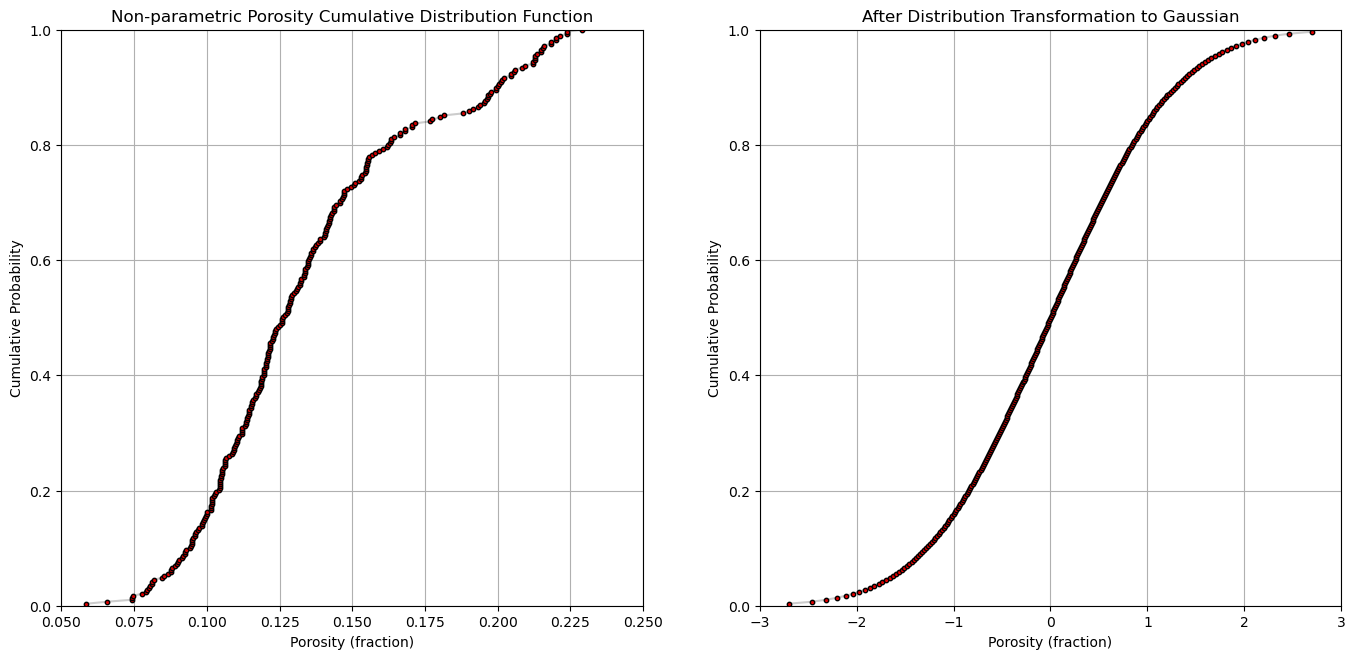

In [22]:
por = df['Porosity'].copy(deep = True).values                 # make a deepcopy of the feature from the DataFrame

por = np.sort(por)                                            # sort the data in ascending order
n = por.shape[0]                                              # get the number of data samples

cprob = np.zeros(n)
for i in range(0,n):
    index = i + 1                                             # select tail assumption by switching the uncommented line below
    cprob[i] = index / n                                      # known upper tail
    # cprob[i] = (index - 1)/n                                # known lower tail
    # cprob[i] = (index - 1)/(n - 1)                          # known upper and lower tails
    # cprob[i] = index/(n+1)                                  # unknown tails  

y = np.zeros(n)

for i in range(0,n):
    y[i] = norm.ppf(cprob[i],loc=0.0,scale=1.0)

plt.subplot(121)
plt.plot(por,cprob, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
plt.scatter(por,cprob,s = 10, alpha = 1.0, c = 'red', edgecolor = 'black') # plot the CDF points
plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("Non-parametric Porosity Cumulative Distribution Function")

plt.subplot(122)
plt.plot(y,cprob, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
plt.scatter(y,cprob,s = 10, alpha = 1.0, c = 'red', edgecolor = 'black') # plot the CDF points
plt.grid(); plt.xlim([-3.0,3.0]); plt.ylim([0.0,1.0])
plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("After Distribution Transformation to Gaussian")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Distribution Transform to a Non-Parametric Distribution

We can apply the mapping through cumulative probabilities to transform from any distribution to any other distribution.

* let's make a new data set by randomly sampling from the previous one and adding error

Then we can demonstrate transforming this dataset to match the original distribution

* this is mimicking the situation where we transform a dataset to match the distribution of a better sampled analog distribution

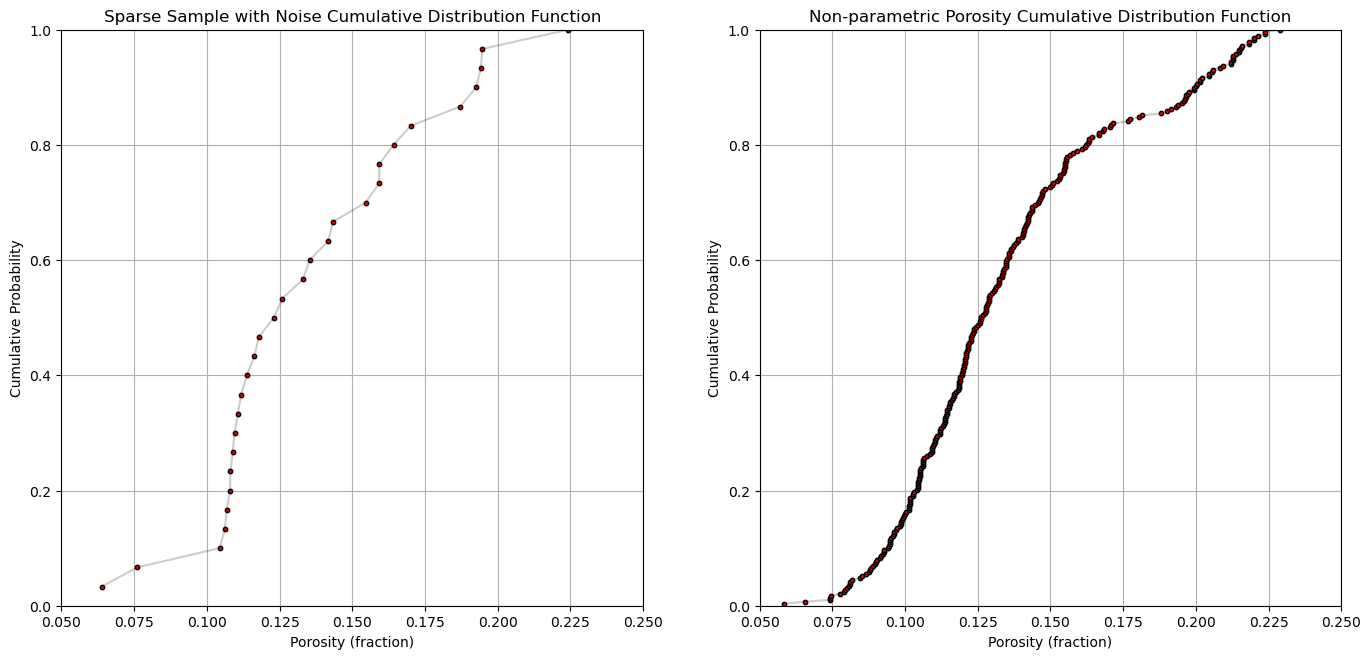

In [23]:
n_sample = 30
df_sample = df.sample(n_sample,random_state = seed)
                      
df_sample = df_sample.copy(deep = True) # make a deepcopy of the feature from the DataFrame

df_sample['Porosity'] = df_sample['Porosity'].values + np.random.normal(loc = 0.0, scale = 0.01, size = n_sample)

df_sample = df_sample.sort_values(by = 'Porosity')                # sort the DataFrame
por_sample = df_sample['Porosity'].values

cprob_sample = np.zeros(n_sample)
for i in range(0,n_sample):
    index = i + 1
    cprob_sample[i] = index / n_sample       # known upper tail
    # cprob[i] = (index - 1)/n               # known lower tail
    # cprob[i] = (index - 1)/(n - 1)         # known upper and lower tails
    # cprob[i] = index/(n+1)                 # unknown tails  

plt.subplot(121)
plt.plot(por_sample,cprob_sample, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
plt.scatter(por_sample,cprob_sample,s = 10, alpha = 1.0, c = 'red', edgecolor = 'black') # plot the CDF points
plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("Sparse Sample with Noise Cumulative Distribution Function")

plt.subplot(122)
plt.plot(por,cprob, alpha = 0.2, c = 'black') # plot piecewise linear interpolation
plt.scatter(por,cprob,s = 10, alpha = 1.0, c = 'red', edgecolor = 'black') # plot the CDF points
plt.grid(); plt.xlim([0.05,0.25]); plt.ylim([0.0,1.0])
plt.xlabel("Porosity (fraction)"); plt.ylabel("Cumulative Probability"); plt.title("Non-parametric Porosity Cumulative Distribution Function")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration of distribution transformations with GeostatsPy. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### About the Author

<figure style="text-align: center;">
  <img src="_static/intro/michael_pyrcz_officeshot_jacket.jpg" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Professor Michael Pyrcz in his office on the 40 acres, campus of The University of Texas at Austin.
</figcaption>
</figure>

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)